In [2]:
import pandas as pd
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import joblib
import re
%matplotlib inline

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("data/train_df.csv")
test = pd.read_csv("data/test_df.csv")
ts_df = pd.read_csv('data/ts_pred.csv')

In [8]:
pred_date = pd.date_range(start='2021-10-16', end='2021-11-05', freq='1D')
pred_date = pred_date.strftime('%Y-%m-%d').tolist()

forecast_date = pd.date_range(start='2021-11-06', end='2021-12-03', freq='1D')
forecast_date = forecast_date.strftime('%Y-%m-%d').tolist()

pred_forecast_date = pred_date + forecast_date

state_list = ts_df.subregion1_code.unique().tolist()

predictors = ' '.join(train.columns)
mob_predictors = re.findall(r'mobility_\w+', predictors)
searchtrend_predictors = re.findall(r'search_trends_\w+', predictors)
ts_predictors = mob_predictors + searchtrend_predictors

In [10]:
static_latest_raw = pd.DataFrame()
for state in state_list:
    find_df = test[test['subregion1_code'] == state]
    find_df['date'] = pd.to_datetime(find_df['date'])
    date_latest = find_df['date'].max()
    state_row = find_df[find_df['date'] == date_latest]
    static_latest_raw = static_latest_raw.append(state_row)

nj_latest = train[(train['subregion1_code']=='NJ')&(train['date']=='2021-10-04')]
static_latest_raw = static_latest_raw.append(nj_latest)

static_latest = static_latest_raw.drop(["date"]+["cumulative_confirmed"]+ts_predictors, axis = 1)
static_latest = static_latest.reset_index(drop = True)

static_df = pd.DataFrame(np.repeat(static_latest.values, len(pred_forecast_date), axis=0))
static_df.columns = static_latest.columns

static_df = static_df.sort_values(by=['subregion1_code'])

static_df = static_df.reset_index(drop = True)
static_df['date'] = pred_forecast_date * len(state_list)

In [11]:
pred_df = pd.merge(ts_df, static_df, on = ['subregion1_code', 'date'])

pred_df['date'] =pd.to_datetime(pred_df['date'])
pred_df = pred_df.sort_values(by=['subregion1_code', 'date'])
pred_df = pred_df.drop(['type'], axis = 1)

In [12]:
res_df = pd.DataFrame()

In [13]:
#for state in static_latest.subregion1_code.unique():
for state in state_list:
    state_col = [state] * (len(pred_date)+len(forecast_date))
    pred_type = ['prediction'] * (len(pred_date))+ ['forecast'] *len(forecast_date)
    pred_curr = pd.DataFrame(list(zip(state_col, pred_date + forecast_date, pred_type)),
                          columns =['subregion1_code', 'date', 'type'])
    
    s_train = train[train["subregion1_code"]==state]
    s_test = pred_df[pred_df["subregion1_code"]==state]
    
    s_train = s_train.drop(["date","subregion1_code",'cumulative_confirmed'], axis = 1)
    s_test = s_test.drop(["date","subregion1_code"], axis = 1)
    
    s_y_train = s_train.new_confirmed
    s_X_train = s_train.drop(["new_confirmed"], axis = 1)

    s_y_test = s_test.new_confirmed
    s_X_test = s_test.drop(["new_confirmed"], axis = 1)
    
    #train initial model
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    rf.fit(s_X_train, s_y_train)
    
    #delete variable that are not important
    forest_importances = pd.Series(rf.feature_importances_, index = s_X_train.columns) 
    no_list = pd.DataFrame(forest_importances[forest_importances<0.001]).index.tolist()
    
    s_X_train_new = s_X_train.drop(no_list, axis = 1)
    s_X_test_new = s_X_test.drop(no_list, axis = 1)
    
    rf2 = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    rf2.fit(s_X_train_new, s_y_train)
    
    s_y_pred_new = rf2.predict(s_X_test_new)
    
    pred_curr['new_confirmed_pred'] = s_y_pred_new
    
    #create prediction dataframe
    res_df = res_df.append(pred_curr)

In [17]:
res_df.to_csv('data/random_forest_final.csv', index = False)

In [ ]:
# sample plot

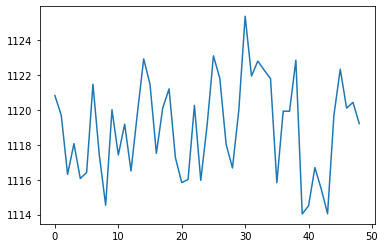

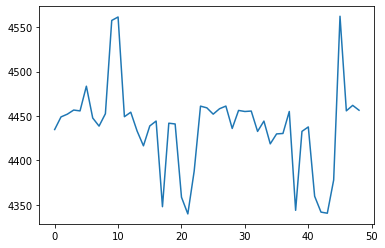

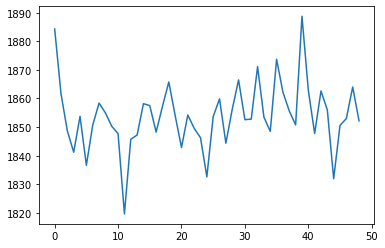

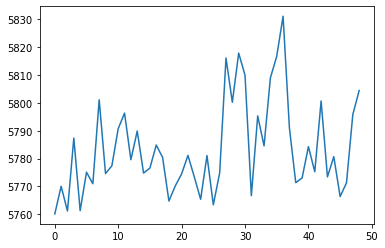

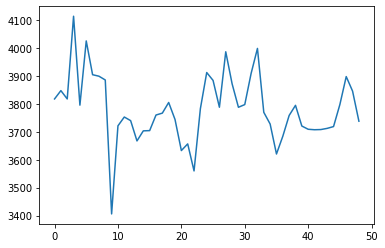

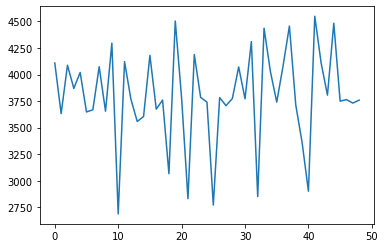

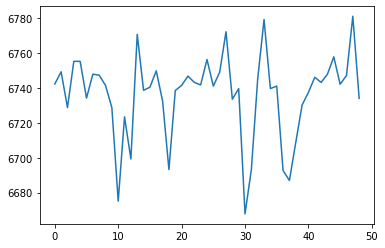

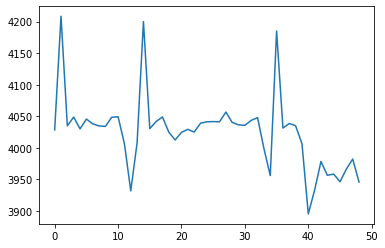

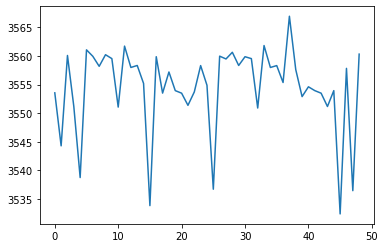

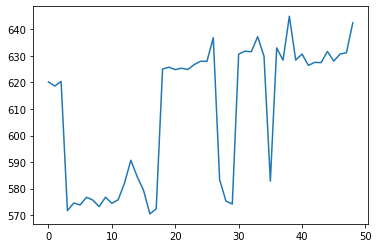

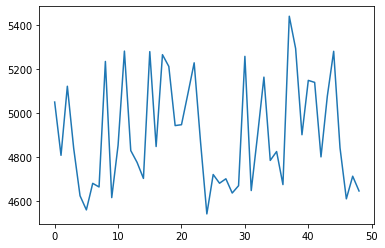

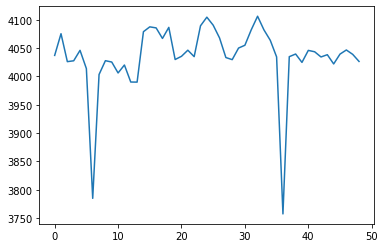

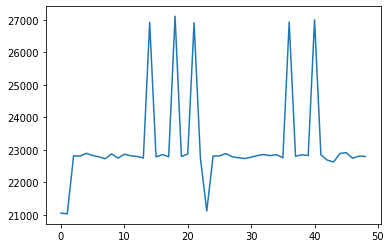

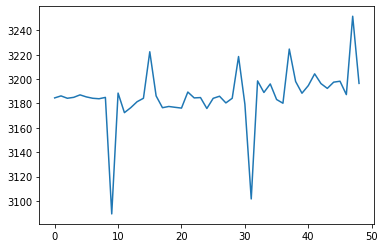

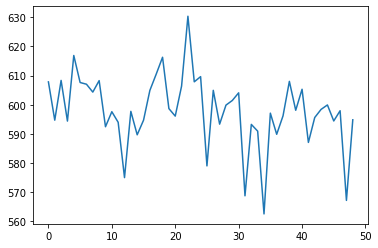

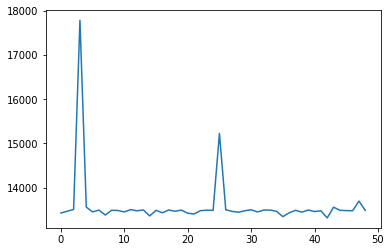

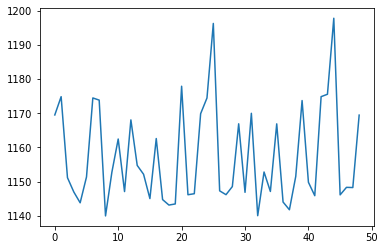

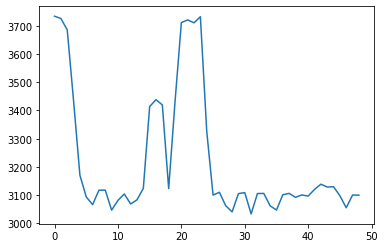

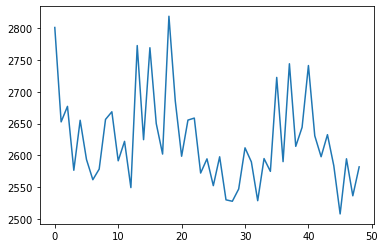

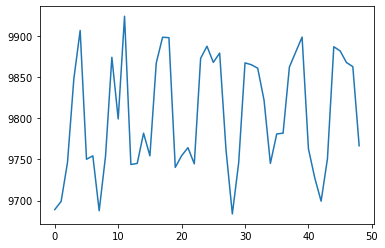

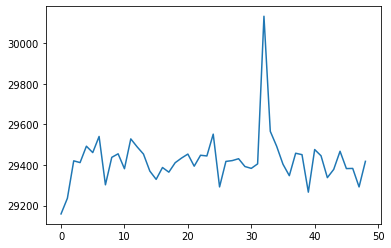

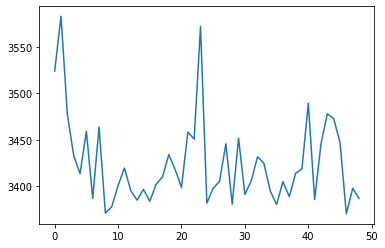

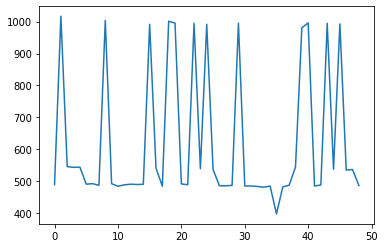

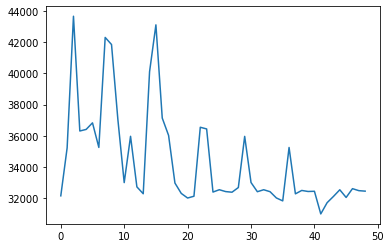

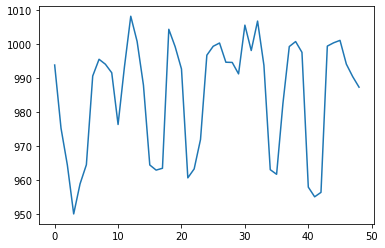

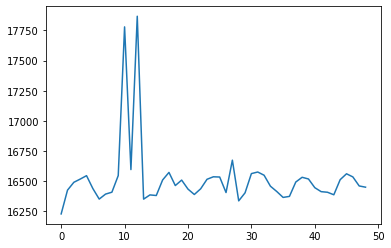

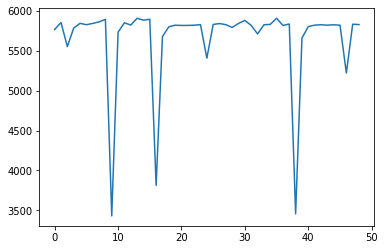

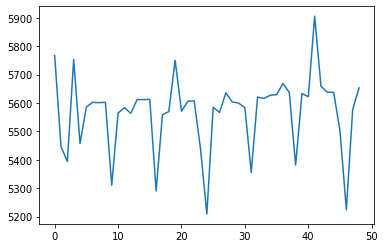

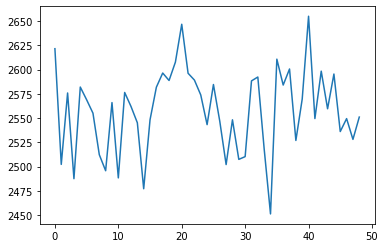

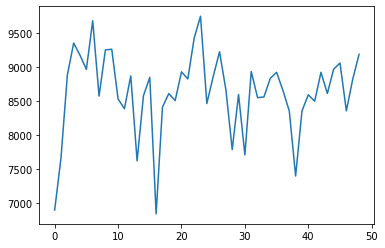

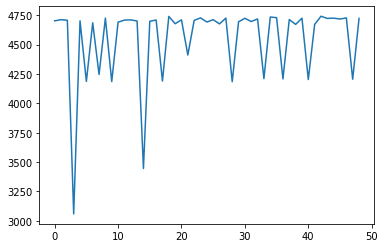

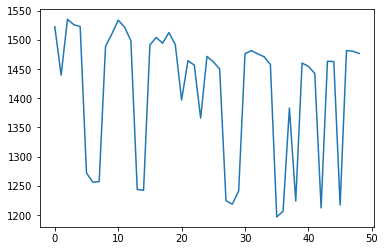

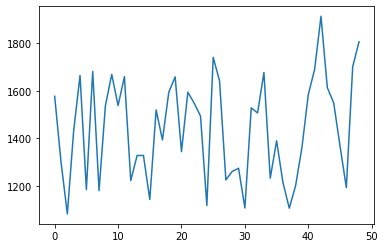

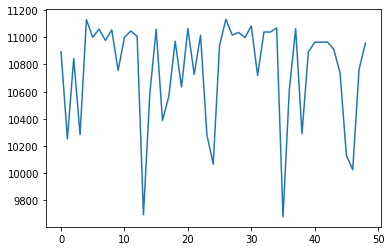

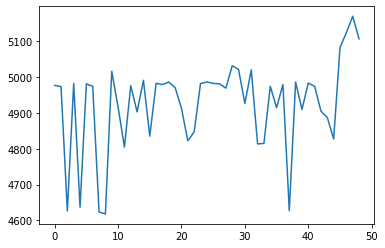

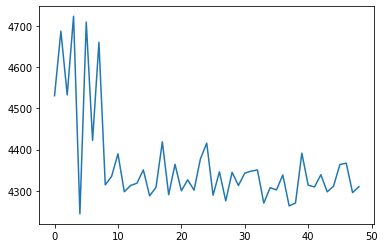

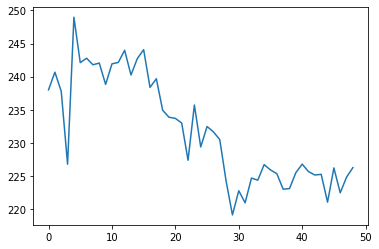

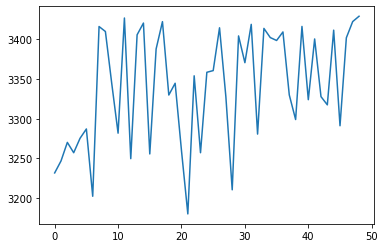

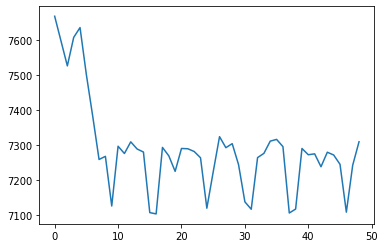

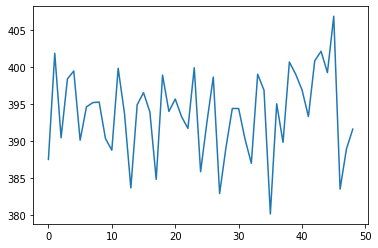

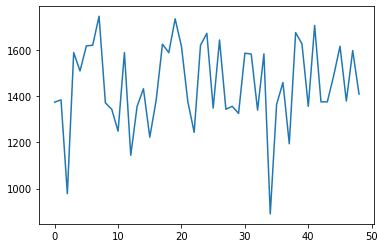

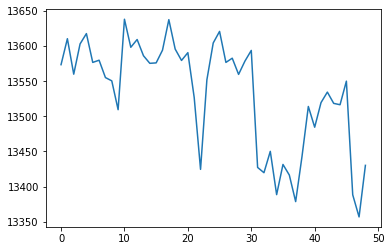

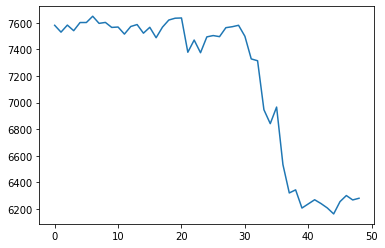

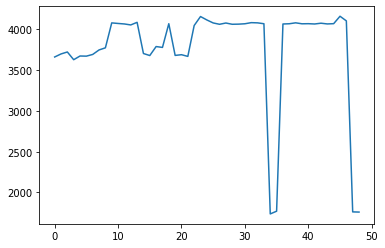

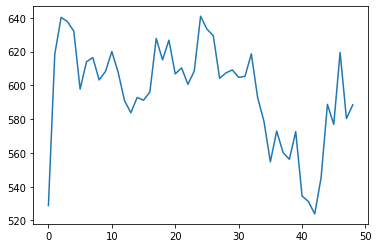

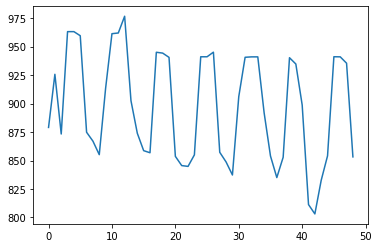

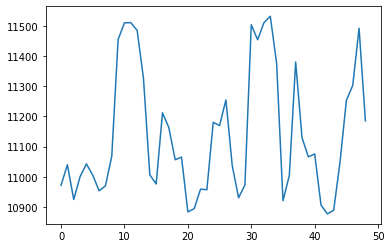

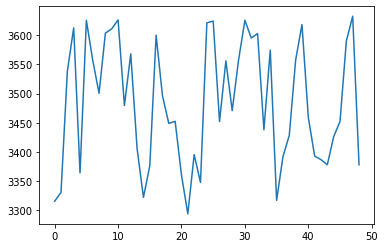

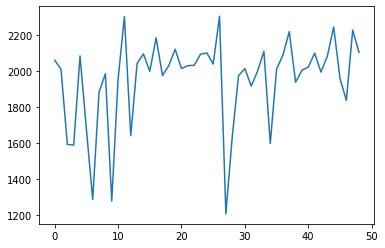

In [16]:
for state in state_list:
    plt.figure()
    plt.plot(res_df[res_df['subregion1_code']==state]['new_confirmed_pred'])